### Create an agentic workflow for that would work as a travel planning assistant

In [512]:
import os
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from pydantic import Field,BaseModel
from typing import List, Optional, Dict
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [513]:

class SelectCityInfo(BaseModel):
    city: str = Field(description="The city where the user is planning to travel")
    start_date: Optional[str] = Field(description="Start date of travel if provided, else the nearest upcoming date")
    end_date: Optional[str] = Field(description="End date of travel if provided, else the nearest upcoming date")
    from_city: Optional[str] = Field(default=None, description="City from which the user is departing (if any)")
    from_currency: Optional[str] = Field(default=None, description="Currency of the departure city/country")
    to_currency: Optional[str] = Field(default=None, description="Currency of the destination city/country")


In [514]:
from langgraph.graph import StateGraph, MessagesState,START,END
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.runnables import RunnablePassthrough
from langchain_community.retrievers import TavilySearchAPIRetriever
tavily_retriever = TavilySearchAPIRetriever(k=3)

In [515]:
def format_docs(docs):
    return '\n\n'.join([doc.page_content for doc in docs])
def configure_llm_model():
    # model = ChatGroq(model='deepseek-r1-distill-llama-70b')
    model = ChatOpenAI(model='gpt-4o-mini')
    output = model.invoke("Hello")
    print(output)
    return model
llm = configure_llm_model()

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BkADlQzFOASCkefNDXXp4WVEkf7Mh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--f19eae8d-fc8a-45f0-a481-6dc53c7c8fd7-0' usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [ ]:
from langchain.tools import tool  

@tool
def select_attraction(query: str) -> str:
    """
    Select four or five tourist attractions in the city specified in the query.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A brief summary listing the top tourist attractions in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of top tourist attractions "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content


@tool
def select_activities(query: str) -> str:
    """
    Select a few popular activities in the city specified in the query.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A brief summary of popular activities in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of the best tourist activities "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content


@tool
def select_restaurants(query: str) -> str:
    """
    Suggest a few of the best restaurants in the specified city.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A brief summary of top-rated restaurants in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of top restaurants "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content


@tool
def search_transportation(query: str) -> str:
    """
    Suggest the best transportation options in the specified city.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A summary of transportation options in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of transportation options "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content

@tool
def extract_cityinfo(query: str):
    """
    Extracts travel info (cities, dates, and currencies) from user query using LLM.
    The model infers all necessary information without any hardcoded mapping.

    Args:
        query (string): User query may or may not contain cities and travel dates.

    Returns:
        string: With extracted city, travel dates, and currencies.
    """
    template = """
    You are a helpful travel assistant. Extract the following fields from the user's query and return the result in JSON format:
    
    - 'city': the destination city where the user plans to travel
    - 'from_city': the departure city from where the user is travelling (if mentioned, else null)
    - 'start_date': the start date of the travel (if mentioned, else null)
    - 'end_date': the end date of the travel (if mentioned, else null)
    - 'from_currency': the currency used in the departure city/country (like INR, USD, EUR)
    - 'to_currency': the currency used in the destination city/country

    user query: {query}
    {format_instructions}
    """

    parser = JsonOutputParser(pydantic_object=SelectCityInfo)
    prompt = PromptTemplate(
        template=template,
        input_variables=['query'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )
    llm_chain = prompt | llm | parser
    cityinfo = llm_chain.invoke(query)

    return (
        f"from_city: {cityinfo.get('from_city',None)}, from_currency: {cityinfo.get('from_currency',None)}, "
        f"to_city: {cityinfo.city}, to_currency: {cityinfo.to_currency}, "
        f"travel start date: {cityinfo.start_date}, travel end date: {cityinfo.end_date}"
    )

@tool
def extract_currentweather(city:str):
    """This function helps extract the current weather situation in the given city.
    
    args :
        city (string) : City name where the user is planning to travel.
    Returns:
        string : A short description of current weather situation including the temperature, hudmidity and wind etc.

    """
    query = f"help me get the current weather condition in {city}" 

    template = """Answer the question based only on the context provided.
        Context: {context}

        Question: {query}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['query','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "query": RunnablePassthrough()}
            | prompt
            | llm
            | StrOutputParser()
            )

    response = chain.invoke(query)
    return {'messages':[response]}

@tool
def weather_forecast(city:str):
    """This function helps search for the weather forecast in the given city.
    
    args :
        city (string) : City name where the user is planning to travel.
    Returns:
        string : A short description of weather forecast in next few days.

    """
    query = f"help me get the weather forecast in {city} for next few days" 

    template = """Answer the question based only on the context provided.
        Context: {context}

        Question: {query}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['query','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "query": RunnablePassthrough()}
            | prompt
            | llm
            | StrOutputParser()
            )

    response = chain.invoke(query)
    return {'messages':[response]}

@tool
def search_hotels(city:str):
    """This function helps search for the hotels in the given city.
    
    args :
        city (string) : City name where the user is planning to travel.
    Returns:
        string : A detailed list of hotels for accomdations within the city.

    """
    query = f"help me search for best hotels in {city} for next few days" 

    template = """Answer the question based only on the context provided. Also provide the hotel price per day stay and different bugdget options"
        Context: {context}. 

        Question: {query}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['query','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "query": RunnablePassthrough()}
            | prompt
            | llm
            | StrOutputParser()
            )

    response = chain.invoke(query)
    return {'messages':[response]}

@tool
def estimate_hotel_cost(number_of_days:int,per_day_amount:float)->float:
    """This function calculates the estimated total cost.
    
    args:
        number_of_days (int) : The number of days the person going to stay in the hotel
        per_day_amount (float) : The amount that will be charged by the hotel per day
    Returns:
        total_cost : returns the estimated total hotel cost """
    
    return number_of_days*per_day_amount

@tool
def get_day_plan(city: str, day_number: int) -> str:
    """
    Generate a travel plan for a specific day in a given city.

    Args:
        city (str): Name of the city for the travel plan.
        day_number (int): The day number of the trip (e.g., 1 for Day 1).

    Returns:
        str: A detailed day-wise plan including attractions, activities, and meal suggestions. Make sure the places in the plan are closer to each other so that it can be covered in a day without any issues.
    """
    prompt = (
        f"You are a travel planner. Help me plan Day {day_number} of a trip to {city}. "
        f"Include major attractions, morning to evening activities, breaks, meals, and transportation tips. "
        f"Keep it concise but useful."
    )
    return llm.invoke([prompt]).content
    

@tool
def create_full_itinerary(city: str, number_of_days: int) -> str:
    """
    Generate a complete travel itinerary for a multi-day trip to a city.

    Args:
        city (str): Name of the destination city.
        number_of_days (int): Total number of days for the trip.

    Returns:
        str: A full itinerary with daily plans, major activities, meals, and tips.
    """
    prompt = (
        f"You are a travel assistant. Help me generate a {number_of_days}-day travel itinerary for a trip to {city}. "
        f"For each day, include major attractions, recommended activities, dining options, and local tips. "
        f"Ensure the plan is enjoyable and well-paced for tourists."
    )
    return llm.invoke([prompt]).content
    



In [517]:
tools = [extract_cityinfo,
         select_attraction,select_activities,select_restaurants,
         search_hotels,search_transportation,extract_currentweather,
         weather_forecast,estimate_hotel_cost,
         get_day_plan, create_full_itinerary]
llm_with_tools = llm.bind_tools(tools)

In [518]:
def llm_descision_step(state:MessagesState):
    query = state['messages']
    SYSTEM_PROMPT = """
        You are a smart travel assistant helping users plan personalized and complete travel itineraries. 
        You can use the following tools to gather accurate, live, and customized data:

        Available tools:
            - extract_cityinfo: Get general information about a city.
            - select_attraction: Recommend popular or must-visit attractions in a city.
            - select_activities: Suggest interesting activities based on preferences and season.
            - select_restaurants: Recommend restaurants based on cuisine, rating, and locality.
            - search_hotels: Search suitable hotels by location, budget, and rating.
            - estimate_hotel_cost: Estimate the cost of a hotel stay based on duration and room type.
            - search_transportation: Suggest transport options for intercity/intracity travel.
            - extract_currentweather: Get current weather details.
            - weather_forecast: Get the forecast for the upcoming days.
            - get_day_plan: Create a plan for a single day of travel with timings and attractions.
            - create_full_itinerary: Combine everything into a full trip itinerary.

        Your tasks:
            - Understand the user’s travel plan: destination, dates, budget, preferences (e.g. food, adventure, culture).
            - Use appropriate tools step by step to gather all data needed for the trip.
            - Plan the full trip: day-by-day breakdown with attractions, activities, weather, hotel info, food, and cost.
            - Make sure suggestions are customized to weather, season, and location.
            - Always return a final detailed and structured output using the `create_full_itinerary` tool after gathering relevant data along with daywise cost and total cost during the trip.

        Your output must be:
            - Friendly, structured, and easy to follow.
            - Clearly divided into days, each with location, activities, meals, and estimated cost.
            - Include hotel name, estimated hotel cost, weather forecasts, and travel tips.
            - Include an approximate daywise and overall cost for the trip in local currency.

        Create a well structured plan with given inputs"""
    prompt = [SYSTEM_PROMPT] + query

    response = llm_with_tools.invoke(prompt)
    return {'messages':[response]}



In [519]:
Tool_Node = ToolNode(tools)

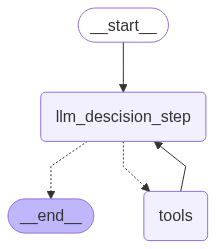

In [520]:
workflow = StateGraph(MessagesState)
workflow.add_node('llm_descision_step',llm_descision_step)
workflow.add_node('tools',Tool_Node)
workflow.add_edge(START,"llm_descision_step")
workflow.add_conditional_edges('llm_descision_step',
                               tools_condition)
workflow.add_edge('tools','llm_descision_step')
app = workflow.compile()
app

In [521]:
state = {'messages':["Help me plan my travel from Bangalore to Paris in last week of Dec 2025 for one week"]}
response = app.invoke(state)
print(response['messages'][-1].content)

### Travel Itinerary for Paris (Last Week of December 2025)

#### Overview
- **Destination:** Paris, France
- **Travel Dates:** Late December 2025 (7 Days)
- **Departure City:** Bangalore, India
- **Estimated Hotel Cost:** Approximately €1,750 for 7 nights (based on €250 per night)
- **Weather Forecast:** Not available yet, but current weather is sunny, around 30°C. Expect winter conditions in late December (cold, possible rain).

### Day 1: Arrival in Paris
- **Activities:**
  - Arrive at Charles de Gaulle Airport.
  - Transfer to hotel (consider using the Metro for cost-effective travel).
  - Check into the **Shangri-La Hotel** (or another preferred choice).
  - Evening stroll along the **Seine River**.
  
- **Meals:** Dinner at a local restaurant.
- **Estimated Cost:** €250 (hotel) + €50 (dinner) = **€300**

---

### Day 2: Explore Iconic Landmarks
- **Activities:**
  - Visit the **Eiffel Tower** in the morning.
  - Lunch at a nearby café.
  - Afternoon at the **Louvre Museum** (res

In [523]:
for i in response['messages']:
    print(i.pretty_print())

================================ Human Message =================================

Help me plan my travel from Bangalore to Paris in last week of Dec 2025 for one week
None
================================== Ai Message ==================================
Tool Calls:
  extract_cityinfo (call_sjSGHpNqZ03vZkiX5LFMCRP9)
 Call ID: call_sjSGHpNqZ03vZkiX5LFMCRP9
  Args:
    query: travel from Bangalore to Paris in last week of Dec 2025 for one week
None
================================= Tool Message =================================
Name: extract_cityinfo

Error: AttributeError("'dict' object has no attribute 'from_city'")
 Please fix your mistakes.
None
================================== Ai Message ==================================
Tool Calls:
  extract_cityinfo (call_WZFYjhq0M8eUm0lS96vcEEaV)
 Call ID: call_WZFYjhq0M8eUm0lS96vcEEaV
  Args:
    query: travel from Bangalore to Paris in last week of Dec 2025 for one week
  weather_forecast (call_3qsZycimoimdrmmJVqilu1ix)
 Call ID: call_3qsZycim